# ***Model A:***
As a supervised regression task. You will use a regression technique for predicting the prices of houses with three bedrooms based on response features that you create from the available data. The resulting dataset should not be time-dependent.

## A1. Perform all data pre-processing steps needed for model A (i.e., integration, cleaning, reduction, and transformation). For each pre-processing step that you apply, dedicate at least one markdown cell next to the code to explain:

*   the step you are applying
*   why you need to do it
*   what is the result

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime  import datetime
from sklearn.utils import resample

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import Sequential,layers,utils,losses
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.models import Sequential

## ***Loading the data***

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Importing the test and train data from the specified location

In [ ]:
train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Data Driven AI/realestate_train.csv')
test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Data Driven AI/realestate_test.csv')
data = pd.concat([train, test], axis=0, ignore_index=True)
print(data.head())

         date   price   type  bedrooms
0  2010-02-07  525000  house         4
1  2010-02-27  290000  house         3
2  2010-03-07  328000  house         3
3  2010-03-09  380000  house         4
4  2010-03-21  310000  house         3


## ***Cleaning the data***

Remove any duplicates

In [ ]:
data.drop_duplicates(inplace=True)

Check for and remove any null values

In [ ]:
print(data.isnull().sum())
data.dropna(inplace=True)

date        0
price       0
type        0
bedrooms    0
dtype: int64


The below code resamples the property type in the train and test data to get better results.

In [ ]:
from sklearn.utils import resample

train_copy = train
test_copy = test

house_data = train[train['type'] == 'house']
unit_data = train[train['type'] == 'unit']


# Randomly sample house data to match the number of unit data
house_sampled = resample(house_data, replace=False, n_samples=9898, random_state=42)

# Use SMOTE to generate synthetic unit data to match the number of house data
unit_sampled = resample(unit_data, replace=True, n_samples=9898, random_state=42)

train_copy = pd.concat([house_sampled, unit_sampled])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f1e5bdce8e0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f1e5bdcee20>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f1e5bdce640>],
 'medians': [<matplotlib.lines.Line2D at 0x7f1e5bd743a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f1e5bd74640>],
 'means': []}

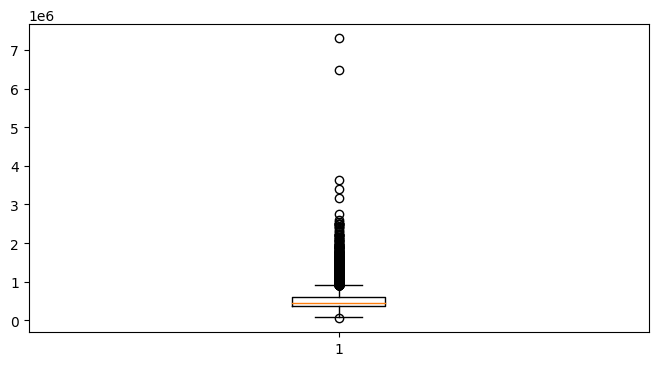

In [ ]:
# this is the dataset before removing outliers
plt.figure(figsize=(8,4))
plt.boxplot(train_copy.price)

## ***Removing Outliers***

In [ ]:
a = np.percentile(train_copy["price"],99.9)
b = np.percentile(test_copy["price"],99.9)
train_copy = train_copy[train_copy["price"] < a]
test_copy = test_copy[test_copy["price"] < b]

The above code gets rid of the outliers in the existing dataset.
After trail and error of substituting multiple threshold limits for determining the outliers we decided to go with 99.9 as the percentile value as it removes outliers while keeping the existing correlation as it does not remove many values from the dataset.

{'whiskers': [<matplotlib.lines.Line2D at 0x7f1e5b4784f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f1e5b478a30>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f1e5b478250>],
 'medians': [<matplotlib.lines.Line2D at 0x7f1e5b478f70>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f1e5b4c26d0>],
 'means': []}

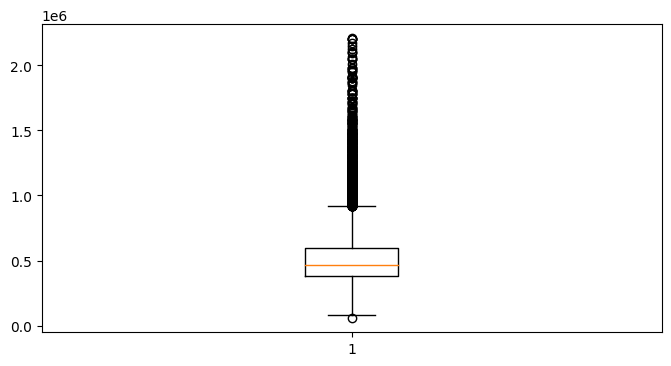

In [ ]:
# this is the dataset after removing outliers
plt.figure(figsize=(8,4))
plt.boxplot(train_copy.price)

In [ ]:
# Converting the date to datetime format
train_copy['date'] = pd.to_datetime(train_copy['date'])
test_copy['date'] = pd.to_datetime(test_copy['date'])

# extracting year and month as a separate column
train_copy['year'] = pd.DatetimeIndex(train_copy['date']).year
train_copy['month'] = pd.DatetimeIndex(train_copy['date']).month

test_copy['year'] = pd.DatetimeIndex(test_copy['date']).year
test_copy['month'] = pd.DatetimeIndex(test_copy['date']).month

<ipython-input-10-5959db14a730>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_copy['date'] = pd.to_datetime(test_copy['date'])
<ipython-input-10-5959db14a730>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_copy['year'] = pd.DatetimeIndex(test_copy['date']).year
<ipython-input-10-5959db14a730>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

# A2. In a separate markdown cell, summarize which features you create and their meaning. Motivate your strategy for creating these features.

Moving average of the prices are found as a response feature for all the properties. It is manually found using the rolling command for the train dataset, while a linear regressor is used to predict the moving average for the prices in test dataset.

In [ ]:
# Moving Average
train_copy['price_moving_average'] = train_copy['price'].rolling(window=2,min_periods=1).mean()
test_copy['dummy'] = test_copy['price'].rolling(window=2,min_periods=1).mean() # moving average for test is found using the prices in the test dataset, but this data is not being used
                                                                               # by the model to learn. Instead it is just used to calculate the accuracy of the predicted moving average.

# Grouping the dataset by finding the mean of the prices for a month
train_copy = train_copy.groupby(['year', 'month', 'type', 'bedrooms'], as_index=False)['price', 'price_moving_average'].mean()
test_copy = test_copy.groupby(['year', 'month', 'type', 'bedrooms'], as_index=False)['price','dummy'].mean()

# One hot encoding for categorizing house and unit property types
train_copy['is_house'] = (train_copy['type'] == 'house').astype(int)
train_copy['is_unit'] = (train_copy['type'] == 'unit').astype(int)

test_copy['is_house'] = (test_copy['type'] == 'house').astype(int)
test_copy['is_unit'] = (test_copy['type'] == 'unit').astype(int)

<ipython-input-11-7912b6e19339>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_copy['dummy'] = test_copy['price'].rolling(window=2,min_periods=1).mean() # moving average for test is found using the prices in the test dataset, but this data is not being used
<ipython-input-11-7912b6e19339>:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  train_copy = train_copy.groupby(['year', 'month', 'type', 'bedrooms'], as_index=False)['price', 'price_moving_average'].mean()
<ipython-input-11-7912b6e19339>:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  test_copy = test_copy.groupby(['year', '

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

# split the train dataset into training and validation sets
train_set, val_set = train_test_split(train_copy, test_size=0.3, random_state=42)

# Define the response variable and the predictor variables
predictor_vars = ['year', 'month', 'bedrooms', 'is_house', 'is_unit']
response_var = 'price_moving_average'

# Define the training, validation, and testing sets
X_train = train_set[predictor_vars]
y_train = train_set[response_var]


X_val = val_set[predictor_vars]
y_val = val_set[response_var]

X_test = test_copy[predictor_vars]
y_test = test_copy['dummy']

In [ ]:
# train a linear regression model on the training set
model = LinearRegression()

model.fit(X_train, y_train)

# evaluate the performance of the model on the validation set
y_val_pred = model.predict(X_val)

mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)
print('Val Accuracy:\n'f'Mean squared error: {mse_val:.3f}\nRMSE: {rmse_val:.3f}\nMean absolute error:{mae_val:.3f}\nR^2 score: {r2_val:.3f}\n')

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Test Accuracy:\n' f'Mean squared error: {mse:.3f}\nRMSE: {rmse:.3f}\nMean absolute error:{mae:.3f}\nR^2 score: {r2:.3f}')

Val Accuracy:
Mean squared error: 7430476515.448
RMSE: 86200.212
Mean absolute error:50565.009
R^2 score: 0.549

Test Accuracy:
Mean squared error: 17044390095.528
RMSE: 130554.165
Mean absolute error:95747.543
R^2 score: 0.506


In [ ]:
test_copy['price_moving_average'] = y_pred

#A3. Prepare your data for model selection and evaluation. What is the experimental setup that you use to build Model A? Please provide a figure that summarizes your setup where you clearly mark:

*   ***How do you split the available data for training, validation, or testing***
    
    Training data is split inot training and validation sets using "train_test_split" from sklearn.model_selection.
*   ***what type of validation strategy do you use (e.g., hold out, cross-validation)***

    Hold out is being used to validate the dataset.

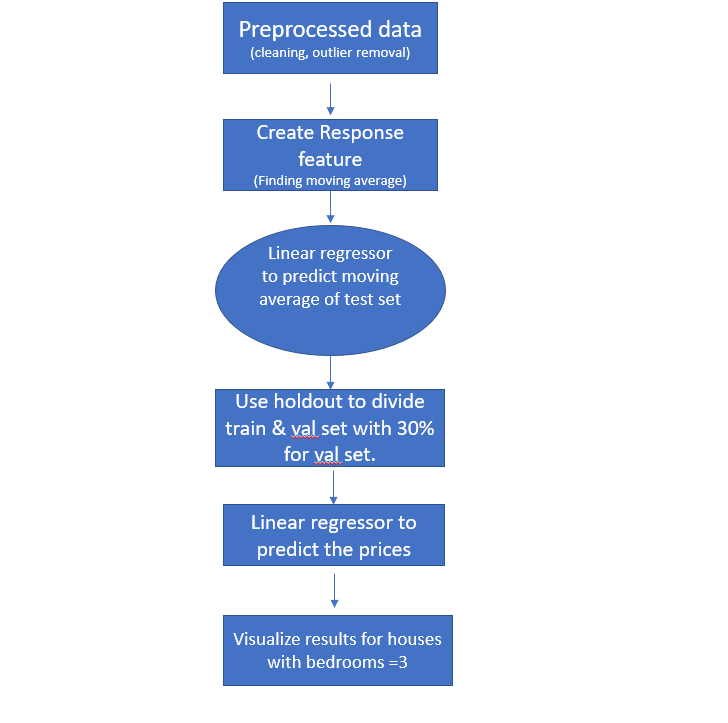





#A4. Choose a machine learning algorithm to build model A (e.g., regression, decision tree, neural network, etc.) and implement your solution. Motivate which hyperparameters you select or optimize.

Linear regression is used to build model A. The train-validation split ratio is set appropriately to optimize the model.


In [ ]:
indices = test_copy[(test_copy['is_house'] == 1) & (test_copy['bedrooms'] == 3)].index.values
indices

array([  1,  10,  18,  26,  35,  43,  50,  60,  67,  77,  85,  93, 101,
       109, 118, 126, 134, 141, 148, 157, 166, 173, 181, 189, 196, 204,
       211, 219, 227, 234, 241])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# split the train dataset into training and validation sets
train_set, val_set = train_test_split(train_copy, test_size=0.3, random_state=42)

# Define the response variable and the predictor variables
response_var = 'price'
predictor_vars = ['year', 'month', 'price_moving_average', 'bedrooms', 'is_house', 'is_unit']

# Define the training, validation, and testing sets
X_train = train_set[predictor_vars]
y_train = train_set[response_var]


X_val = val_set[predictor_vars]
y_val = val_set[response_var]

X_test = test_copy[predictor_vars]
y_test = test_copy[response_var]

In [ ]:
# train a linear regression model on the training set
model = LinearRegression()
#model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# evaluate the performance of the model on the validation set
y_val_pred = model.predict(X_val)

mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)
print('Val Accuracy:\n'f'Mean squared error: {mse_val:.3f}\nRMSE: {rmse_val:.3f}\nMean absolute error:{mae_val:.3f}\nR^2 score: {r2_val:.3f}\n')

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Test Accuracy for the entirety of the dataset:\n' f'Mean squared error: {mse:.3f}\nRMSE: {rmse:.3f}\nMean absolute error:{mae:.3f}\nR^2 score: {r2:.3f}')

Val Accuracy:
Mean squared error: 5888455176.169
RMSE: 76736.270
Mean absolute error:47851.608
R^2 score: 0.841

Test Accuracy for the entirety of the dataset:
Mean squared error: 12593475952.841
RMSE: 112220.657
Mean absolute error:80659.376
R^2 score: 0.737


# A5. Evaluate the performance of model A. Describe which measures you use and discuss the results of the evaluation.

In [ ]:
y_test = y_test[indices]
y_pred = y_pred[indices]

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Test Accuracy for 3 bedroom houses:\n' f'Mean squared error: {mse:.3f}\nRMSE: {rmse:.3f}\nMean absolute error:{mae:.3f}\nR^2 score: {r2:.3f}')

Test Accuracy for 3 bedroom houses:
Mean squared error: 376705279.220
RMSE: 19408.897
Mean absolute error:13064.022
R^2 score: 0.219


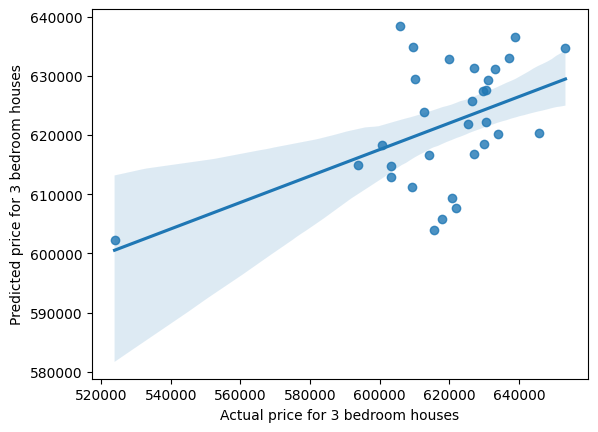

In [ ]:
# create a DataFrame to hold the actual and predicted values
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# plot the actual vs. predicted values with a linear regression fit
sns.regplot(x='Actual', y='Predicted', data=results)
plt.xlabel("Actual price for 3 bedroom houses")
plt.ylabel("Predicted price for 3 bedroom houses")
plt.show()

<ipython-input-20-3e53733669ac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dope['Year-Month'] = dope['year'].astype(str) + '-' + dope['month'].astype(str)
<ipython-input-20-3e53733669ac>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dope['Year-Month'] = pd.to_datetime(dope['Year-Month'])


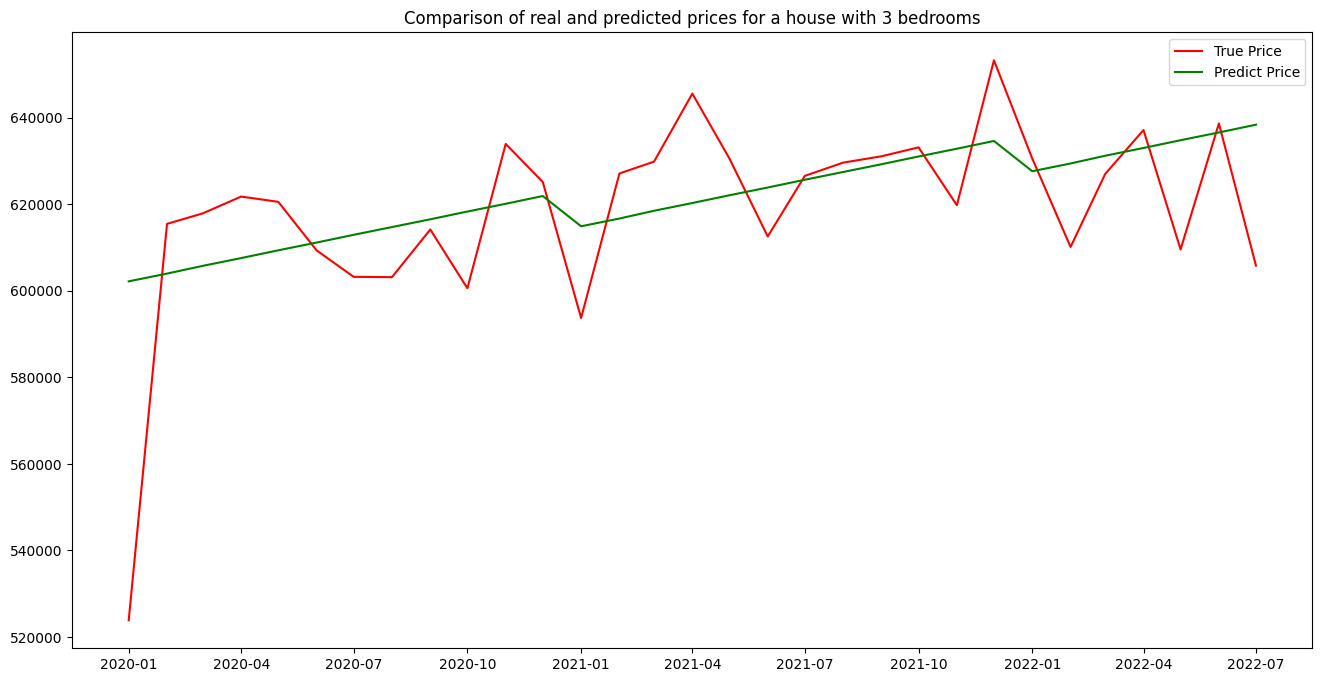

In [ ]:
dope = test_copy[(test_copy['is_house'] == 1) & (test_copy['bedrooms'] == 3)]
dope['Year-Month'] = dope['year'].astype(str) + '-' + dope['month'].astype(str)
dope['Year-Month'] = pd.to_datetime(dope['Year-Month'])
plt.figure(figsize=(16,8))
plt.plot(dope['Year-Month'],results['Actual'],color='red',label='True Price')
plt.plot(dope['Year-Month'],results['Predicted'],color='green',label='Predict Price')
plt.legend(loc='best')
plt.title("Comparison of real and predicted prices for a house with 3 bedrooms")
plt.show()

# ***Model B:***
As a time series forecasting task. You will use a recurrent neural network architecture (e.g., LSTM) to predict the prices of houses with three bedrooms based on the previous prices of all properties. Your data will be in the form of time-dependent sequences.

## B1. Perform all data pre-processing steps needed for model B (i.e., integration, cleaning, reduction, and transformation). For each pre-processing step that you apply, dedicate at least one markdown cell next to the code to explain:

## ***Cleaning the data***

Remove any duplicates

In [ ]:
data.drop_duplicates(inplace=True)

Check for and remove any null values

In [ ]:
print(data.isnull().sum())
data.dropna(inplace=True)

date        0
price       0
type        0
bedrooms    0
dtype: int64


Remove outlier of "price" and check

{'whiskers': [<matplotlib.lines.Line2D at 0x7f1e47c5cbe0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f1e47c5c310>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f1e47c5c7c0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f1e47f8b6d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f1e47f8ba60>],
 'means': []}

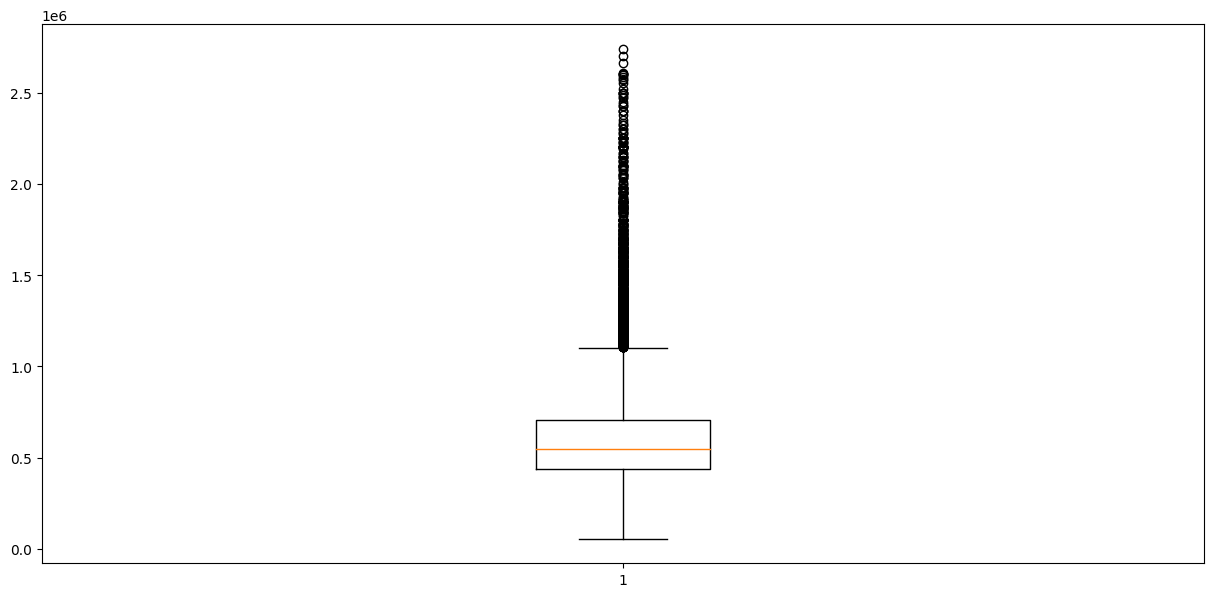

In [ ]:
bias = np.percentile(data["price"],99.9)
data = data[data["price"] < bias]
plt.figure(figsize=(15,7))
plt.boxplot(data.price)

In [ ]:
data

,date,price,type,bedrooms
0,2010-02-07,525000,house,4
1,2010-02-27,290000,house,3
2,2010-03-07,328000,house,3
3,2010-03-09,380000,house,4
4,2010-03-21,310000,house,3
...,...,...,...,...
29575,2022-07-25,500000,unit,3
29576,2022-07-25,560000,unit,2
29577,2022-07-26,464950,unit,2
29578,2022-07-26,589000,unit,2


Convert date to datetime format, and calculate the average price by grouping the data for different number and types of houses

In [ ]:
data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'] - pd.offsets.MonthBegin(1)
data = data.groupby(['date', 'type', 'bedrooms'], as_index=False)['price'].mean()
data

,date,type,bedrooms,price
0,2010-02-01,house,3,290000.000000
1,2010-02-01,house,4,525000.000000
2,2010-03-01,house,3,319000.000000
3,2010-03-01,house,4,380000.000000
4,2010-04-01,house,3,399000.000000
...,...,...,...,...
1104,2022-07-01,house,5,892000.000000
1105,2022-07-01,unit,0,199000.000000
1106,2022-07-01,unit,1,338970.588235
1107,2022-07-01,unit,2,428866.333333


Create a new column "type_class", map the value of "house" to 1 and the value of "units" to 0.

The purpose of this step is to do pre-processing for LSTM test, since types is a binary mathematics, it is convenient for the algorithm to identify them with 1,0.

In [ ]:
data['type_class'] = data['type'].map({'house': 1, 'unit': 0})
data = data.drop(['type'], axis=1)
data

,date,bedrooms,price,type_class
0,2010-02-01,3,290000.000000,1
1,2010-02-01,4,525000.000000,1
2,2010-03-01,3,319000.000000,1
3,2010-03-01,4,380000.000000,1
4,2010-04-01,3,399000.000000,1
...,...,...,...,...
1104,2022-07-01,5,892000.000000,1
1105,2022-07-01,0,199000.000000,0
1106,2022-07-01,1,338970.588235,0
1107,2022-07-01,2,428866.333333,0


Move price column to the second column.

The purpose of this step is, since the price is our prediction, to move it to the second column to facilitate the separation of the data later

In [ ]:
columns = list(data.columns)
columns.insert(1, columns.pop(columns.index('price')))
data = data.reindex(columns=columns)

#B2. In a separate markdown cell, summarize how you organize your time-dependent data. Motivate your strategy. You can include a figure if needed.

First we put the train data and the test data into a data dataset to pre-process the two data.
1. Then we proceeded to clean both data, checked and removed duplicates and null values, and secondly removed outliers.
2. Converted date to datetime format, and calculated the average price by grouping the data for different number and types of houses.
3. Created a new column "type_class", map the value of "house" to 1 and the value of "units" to 0.
4. Moved price column to the second column.
5. Observed the relationship between the indicators and consider whether there is a correlation and whether further processing of the indicators is required.

Finally we could get a neat structure of the dataset, and we concluded that bedrooms has 0,1,2,3,4,5 six values which can be used as a feature, so we retained it, and converted house and units from character type to 1,0 number type as a binary indicator.




## ***Visualization***

Observe the relationship between the indicators and consider whether there is a correlation and whether further processing of the indicators is required.


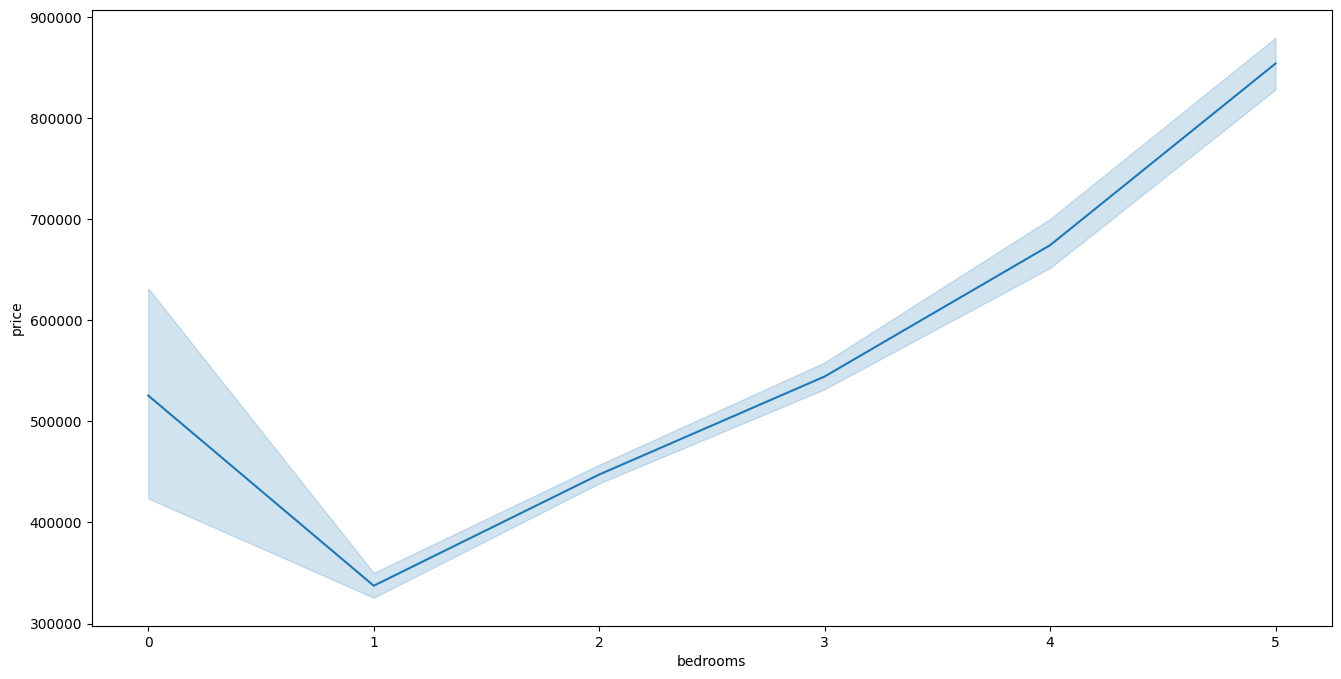

In [ ]:
# bedrooms and price
plt.figure(figsize=(16,8))
sns.lineplot(x='bedrooms',y='price',data=data)
plt.show()

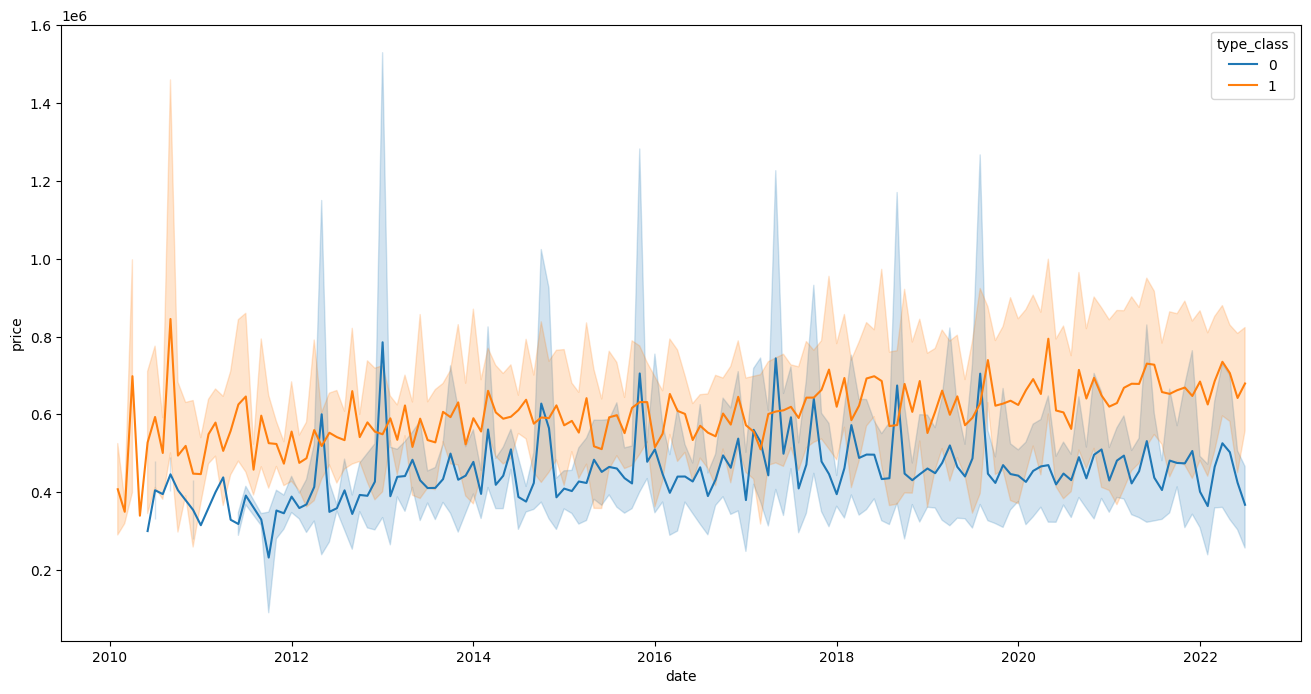

In [ ]:
# type and price (type 1= house,0=unit)
plt.figure(figsize=(16,8))
sns.lineplot(x='date',y='price',data=data,hue='type_class')
plt.show()

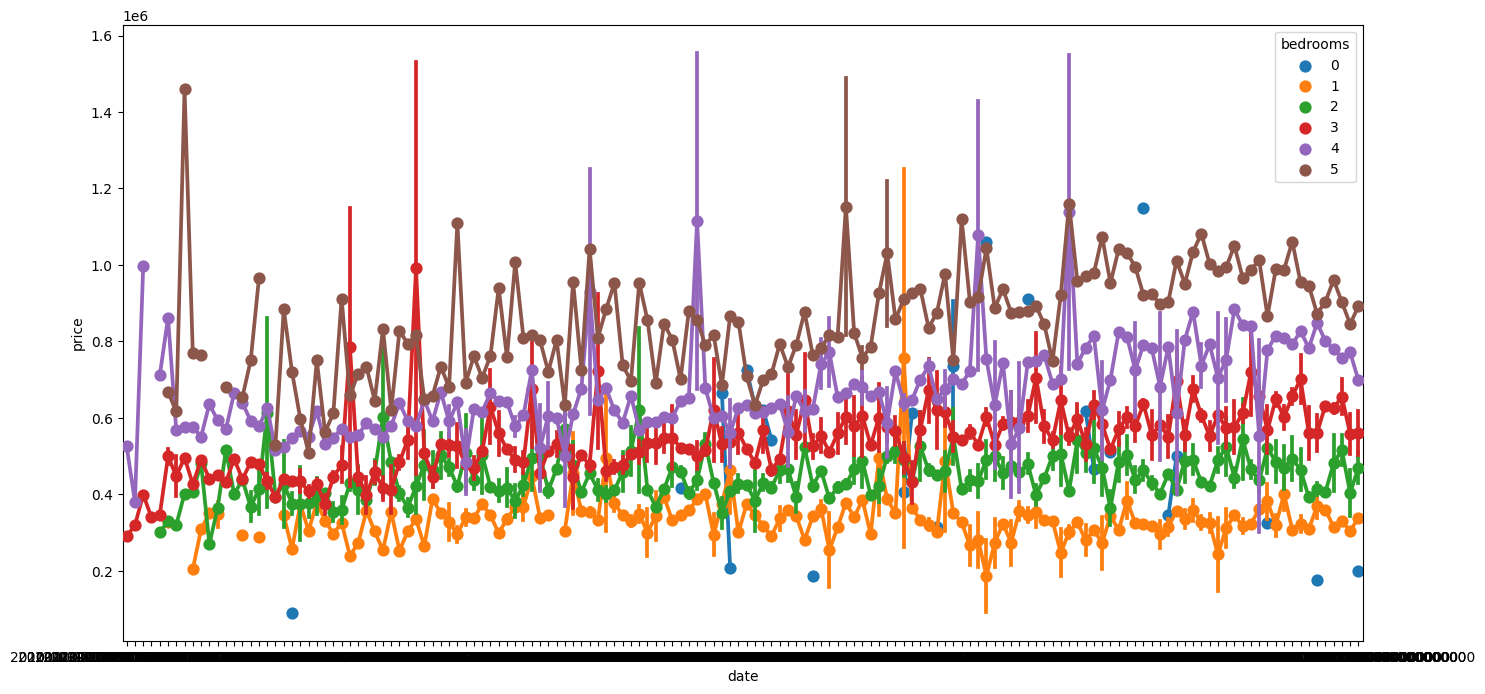

In [ ]:
# bedrooms and price (bedrooms=0,1,2,3,4,5)
plt.figure(figsize=(16,8))
sns.pointplot(x='date',y='price',data=data,hue='bedrooms')
plt.show()

After observation I decided to use all features to participate in the calculation.



#B3. Prepare your data for model selection and evaluation. What is the experimental setup that you use to build Model B? Please provide a figure that summarizes your setup where you clearly mark:


*   ***How do you split the available data for training, validation, or testing***
    
    Training data is split into training and validation sets using "train_test_split" from sklearn.model_selection.
*   ***what type of validation strategy do you use (e.g., hold out, cross-validation)***

    Hold out is being used to validate the dataset.

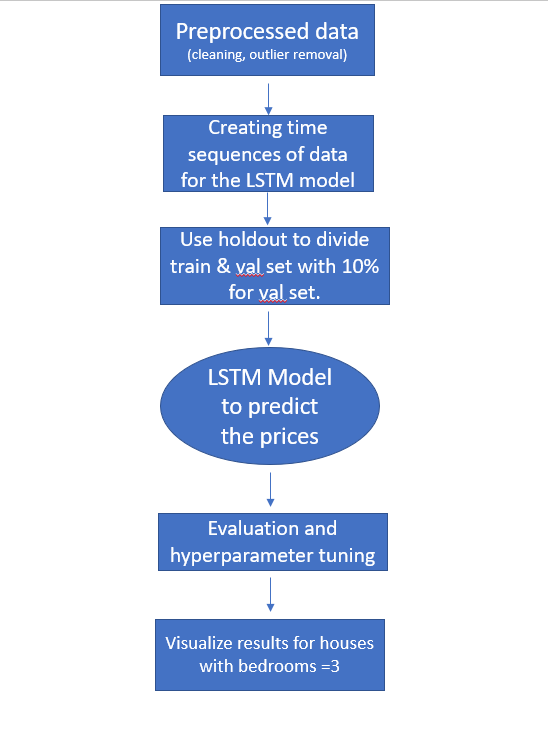
  

## ***Split the data into training and testing sets***

Set date to index


In [ ]:
train_data = data[data['date'] < '2020-01-01']
test_data = data[data['date'] >= '2020-01-01']

# Get the last six rows of train_data
last_six_rows = train_data.tail(6)

# Add last_six_rows to the front of test_data
test_data = pd.concat([last_six_rows, test_data]).reset_index(drop=True)

train_data.set_index('date', inplace=True)
test_data.set_index('date', inplace=True)

## ***Normalizing the data for special columns***

In [ ]:
scaler = MinMaxScaler()
train_data['price'] =scaler.fit_transform(train_data['price'].values.reshape(-1,1))
test_data['price'] = scaler.transform(test_data['price'].values.reshape(-1,1))

<ipython-input-32-fe8c4d1808e5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['price'] =scaler.fit_transform(train_data['price'].values.reshape(-1,1))


##***Split the data into feature data and response data, where my feature data is house(num=1,2,3,4,5),type_class(house=1,units=0)***


In [ ]:
# feature data
X = train_data.drop(columns=['price'],axis=1)
X_test = test_data.drop(columns=['price'],axis=1)

#label data
y = train_data['price']
y_test = test_data['price']


#**splitting the training data into a training set and a validation set**


In [ ]:
# split the train dataset into training and validation sets
X_train, X_val,y_train,y_val = train_test_split(X,y, test_size=0.1,shuffle=False,random_state=666)

# ***Converting data to a form suitable for LSTM model input***

###***Create feature datasets***

In [ ]:
def create_sequences(X,y,seq_length):
    features = []
    targets = []
    for i in range(0, len(X) - seq_length, 1):
        data = X.iloc[i:i+seq_length].values #sequences data
        # to_numpy()
        label = y.iloc[i+seq_length] #label data
        #save to list
        features.append(data)
        targets.append(label)

    return  np.array(features),np.array(targets)

In [ ]:
seq_length = 4
train_dataset,train_labels = create_sequences(X_train,y_train, seq_length)
val_dataset,val_labels = create_sequences(X_val,y_val,seq_length)
test_dataset,test_labels = create_sequences(X_test,y_test,seq_length)

###***Create Batch_size***

In [ ]:
def create_batch_dataset(X,y,train=True,buffer_size=1000,batch_size=64):
    batch_data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
    if train:
        return batch_data.cache().shuffle(buffer_size).batch(batch_size)
    else:
        return batch_data.batch(batch_size)

In [ ]:
#Train_batch_size
train_batch_dataset = create_batch_dataset(train_dataset,train_labels)

#Val batch_size
val_batch_dataset =create_batch_dataset(val_dataset,val_labels,train=False)

Test data structure

In [ ]:
list(val_batch_dataset.as_numpy_iterator())[0]

(array([[[2, 0],
         [3, 0],
         [4, 0],
         [0, 1]],
 
        [[3, 0],
         [4, 0],
         [0, 1],
         [1, 1]],
 
        [[4, 0],
         [0, 1],
         [1, 1],
         [2, 1]],
 
        [[0, 1],
         [1, 1],
         [2, 1],
         [3, 1]],
 
        [[1, 1],
         [2, 1],
         [3, 1],
         [4, 1]],
 
        [[2, 1],
         [3, 1],
         [4, 1],
         [5, 1]],
 
        [[3, 1],
         [4, 1],
         [5, 1],
         [1, 0]],
 
        [[4, 1],
         [5, 1],
         [1, 0],
         [2, 0]],
 
        [[5, 1],
         [1, 0],
         [2, 0],
         [3, 0]],
 
        [[1, 0],
         [2, 0],
         [3, 0],
         [1, 1]],
 
        [[2, 0],
         [3, 0],
         [1, 1],
         [2, 1]],
 
        [[3, 0],
         [1, 1],
         [2, 1],
         [3, 1]],
 
        [[1, 1],
         [2, 1],
         [3, 1],
         [4, 1]],
 
        [[2, 1],
         [3, 1],
         [4, 1],
         [5, 1]],
 
      

# B4. Choose a recurrent neural network architecture to build model B (e.g., LSTM, GRU, etc.) and implement your solution. Motivate which hyperparameters you select or optimize.

# ***Define the model***



I choose to use LSTM for temporal prediction, after many times of tuning, I found that for our data, when the number of neurons in the model structure is small, such as 32->16->8, we can get better results, when the number of neurons is larger, such as 256->128->64, the effect becomes worse, and the loss drop is more volatile.

In [ ]:
model = Sequential([
    layers.LSTM(units=32,activation='LeakyReLU',input_shape=train_dataset.shape[-2:],return_sequences=True),
    layers.Dropout(0.1),
    layers.LSTM(units=16,activation='LeakyReLU',return_sequences=True), #32
    layers.Dropout(0.1),
    layers.LSTM(units=2,activation='LeakyReLU'), #8
    layers.Dense(1)
])

###***Output model structure***

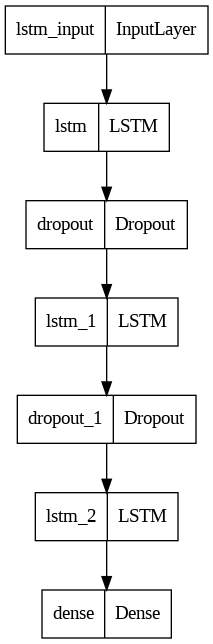

In [ ]:
utils.plot_model(model)

###***Compile the model***

In [ ]:
model.compile(optimizer='adam',
            loss='mse',
            metrics=['mape'])

In [ ]:
checkpoint_file = 'best_model.hdf5'

checkpoint_callback = ModelCheckpoint(filepath=checkpoint_file,
                                      monitor='loss',
                                      mode='min',
                                      save_best_only=True,
                                      save_weights_only=True)

###***Fit the model on the training data***

In [ ]:
history = model.fit(train_batch_dataset,
                    epochs=100,
                    validation_data=val_batch_dataset,
                    callbacks=[checkpoint_callback])

Epoch 1/100
12/12 [==============================] - 11s 81ms/step - loss: 0.1056 - mape: 4578.4331 - val_loss: 0.1247 - val_mape: 94.0962
Epoch 2/100
12/12 [==============================] - 0s 34ms/step - loss: 0.0912 - mape: 35752.9297 - val_loss: 0.1041 - val_mape: 80.2071
Epoch 3/100
12/12 [==============================] - 0s 33ms/step - loss: 0.0696 - mape: 82355.5781 - val_loss: 0.0802 - val_mape: 63.4491
Epoch 4/100
12/12 [==============================] - 0s 33ms/step - loss: 0.0474 - mape: 123705.6406 - val_loss: 0.0535 - val_mape: 45.5591
Epoch 5/100
12/12 [==============================] - 0s 34ms/step - loss: 0.0269 - mape: 348358.2500 - val_loss: 0.0349 - val_mape: 54.3474
Epoch 6/100
12/12 [==============================] - 0s 32ms/step - loss: 0.0227 - mape: 412126.5000 - val_loss: 0.0332 - val_mape: 52.0221
Epoch 7/100
12/12 [==============================] - 0s 36ms/step - loss: 0.0208 - mape: 427623.3438 - val_loss: 0.0335 - val_mape: 47.1358
Epoch 8/100
12/12 [====

## ***Show result***

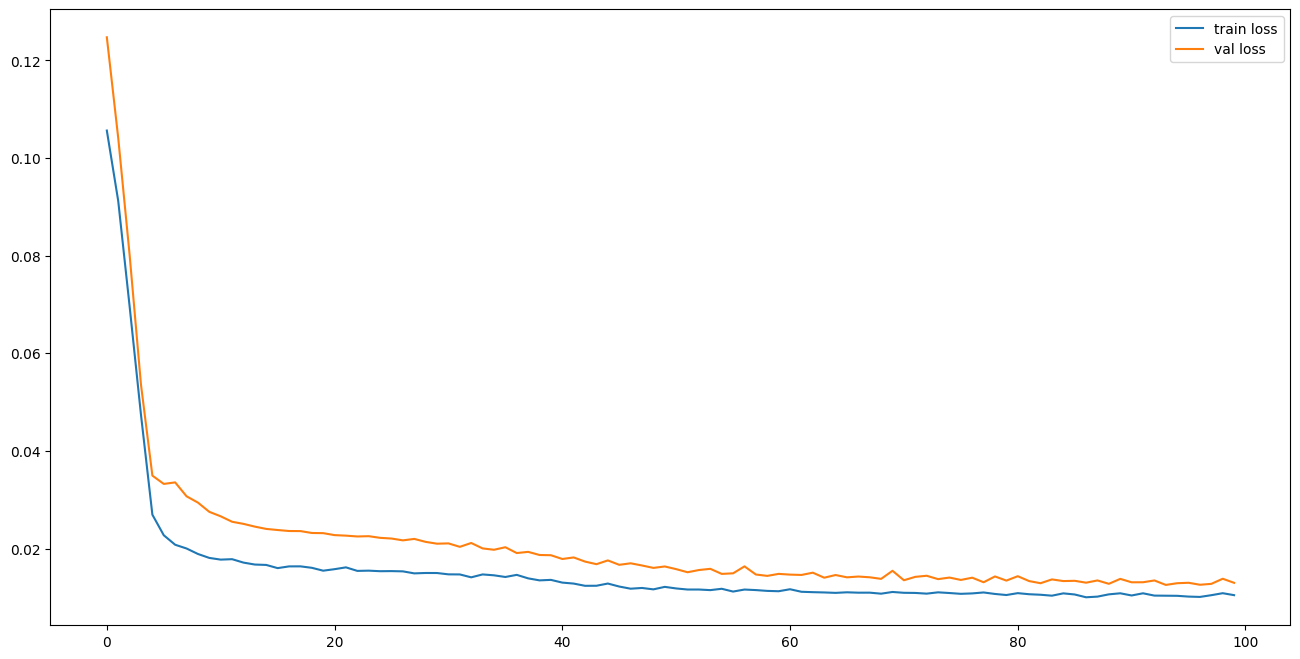

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.legend(loc='best')
plt.show()

#B5. Evaluate the performance of model B. Describe which measures you use and discuss the results of the evaluation.

#***Make predictions on the test data***

In [ ]:
test_pred = model.predict(test_dataset,verbose=1)

8/8 [==============================] - 0s 4ms/step


###***Processing model prediction results in a format that facilitates evaluation calculations***

In [ ]:
test_pred = test_pred[:,0]

## ***Calculate the evaluation metrics***

In [ ]:
r2 = r2_score(test_labels, test_pred)
mse = mean_squared_error(test_labels, test_pred)

print("R-squared score: {:.6f}".format(r2))
print("Mean squared error: {:.6f}".format(mse))

R-squared score: 0.588910
Mean squared error: 0.009129


## ***Show Price result***

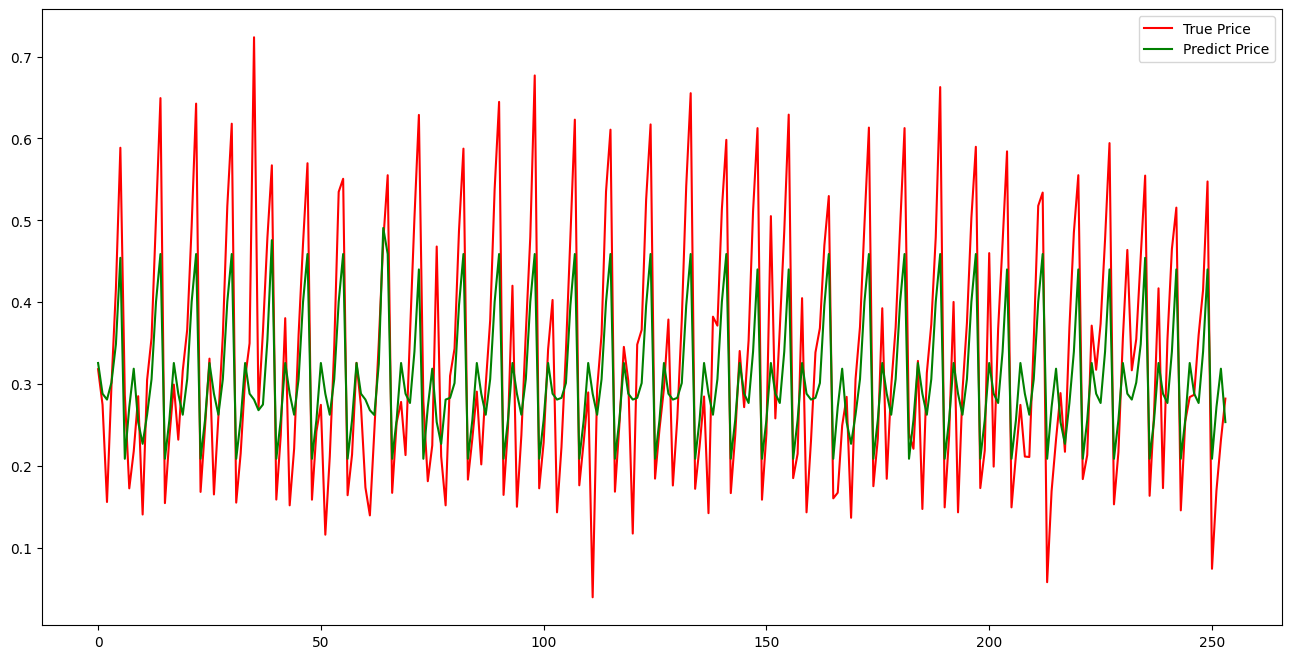

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(test_labels,color='red',label='True Price')
plt.plot(test_pred,color='green',label='Predict Price')
plt.legend(loc='best')
plt.show()

#***Change the format of forecast results, for comparison and forecast prices***

In [ ]:
test_pred = np.reshape(test_pred, (-1, 1))
test_dataset_reshape = test_dataset[:, 0, :]
test_dataset_reshape = test_dataset_reshape[4:, :]
test_data_pred = np.concatenate((test_dataset_reshape, test_pred[:250]), axis=1)
df_pred = pd.DataFrame(test_data_pred, columns=['bedrooms', 'type_class', 'price'])

test_data['bedrooms'] = test_data['bedrooms'].astype('float64')
test_data['type_class'] = test_data['type_class'].astype('float64')
test_data = test_data.reset_index()

test_data = test_data.iloc[4:-4]
test_data = test_data.reset_index(drop=True)

## ***Compare the real price with the predicted price (for the type of house with bedroom=3)***

In [ ]:
merged_df_pred = test_data.merge(df_pred,
                                  left_index=True, right_index=True,
                                  suffixes=('_True', '_Pred'),
                                  )
merged_df_pred = merged_df_pred[(merged_df_pred['bedrooms_True'] == 3.0) &
                            (merged_df_pred['type_class_True'] == 1.0) &
                            (merged_df_pred['bedrooms_Pred'] == 3.0) &
                            (merged_df_pred['type_class_Pred'] == 1.0)]
merged_df_pred = merged_df_pred.drop(['bedrooms_Pred','type_class_Pred'],axis=1)
merged_df_pred.rename(columns={'bedrooms_True': 'Bedrooms', 'type_class_True': 'Type_class'}, inplace=True)

### **Calculate the evaluation metrics of real and predicted prices for a house with 3 bedrooms***

In [ ]:
# mse = mean_squared_error(merged_df_pred['price_True'], merged_df_pred['price_Pred'])

# print("Mean squared error: {:.6f}".format(mse))

### ***Show the Price table***

In [ ]:
merged_df_pred['price_True'] = scaler.inverse_transform(merged_df_pred['price_True'].values.reshape(-1, 1))
merged_df_pred['price_Pred'] = scaler.inverse_transform(merged_df_pred['price_Pred'].values.reshape(-1, 1))
new_cols = ['date','Bedrooms', 'Type_class', 'price_True', 'price_Pred']
merged_df_pred= merged_df_pred[new_cols]
merged_df_pred

,date,Bedrooms,Type_class,price_True,price_Pred
3,2020-01-01,3.0,1.0,526402.830189,532241.061181
12,2020-02-01,3.0,1.0,612185.148936,538393.248469
20,2020-03-01,3.0,1.0,626842.857143,538393.248469
28,2020-04-01,3.0,1.0,616672.205882,538393.248469
37,2020-05-01,3.0,1.0,623847.059259,492857.064307
45,2020-06-01,3.0,1.0,617618.270270,538393.248469
53,2020-07-01,3.0,1.0,595395.161290,538393.248469
63,2020-08-01,3.0,1.0,603459.377483,565567.133576
70,2020-09-01,3.0,1.0,617954.167883,495640.327632
80,2020-10-01,3.0,1.0,592835.763889,531309.610158


### **Calculate the evaluation metrics of real and predicted prices for a house with 3 bedrooms***

In [ ]:
mse_real = mean_squared_error(merged_df_pred['price_True'], merged_df_pred['price_Pred'])
rmse = np.sqrt(mse_real)
mae = mean_absolute_error(merged_df_pred['price_True'], merged_df_pred['price_Pred'])
r2 = r2_score(merged_df_pred['price_True'], merged_df_pred['price_Pred'])
print('Test Accuracy for 3 bedroom houses:\n' f'Mean squared error: {mse_real:.3f}\nRMSE: {rmse:.3f}\nMean absolute error:{mae:.3f}\nR^2 score: {r2:.3f}')

Test Accuracy for 3 bedroom houses:
Mean squared error: 9540921118.593
RMSE: 97677.639
Mean absolute error:92970.968
R^2 score: -19.066


In [ ]:
len(merged_df_pred)

31

#***Show Price result***

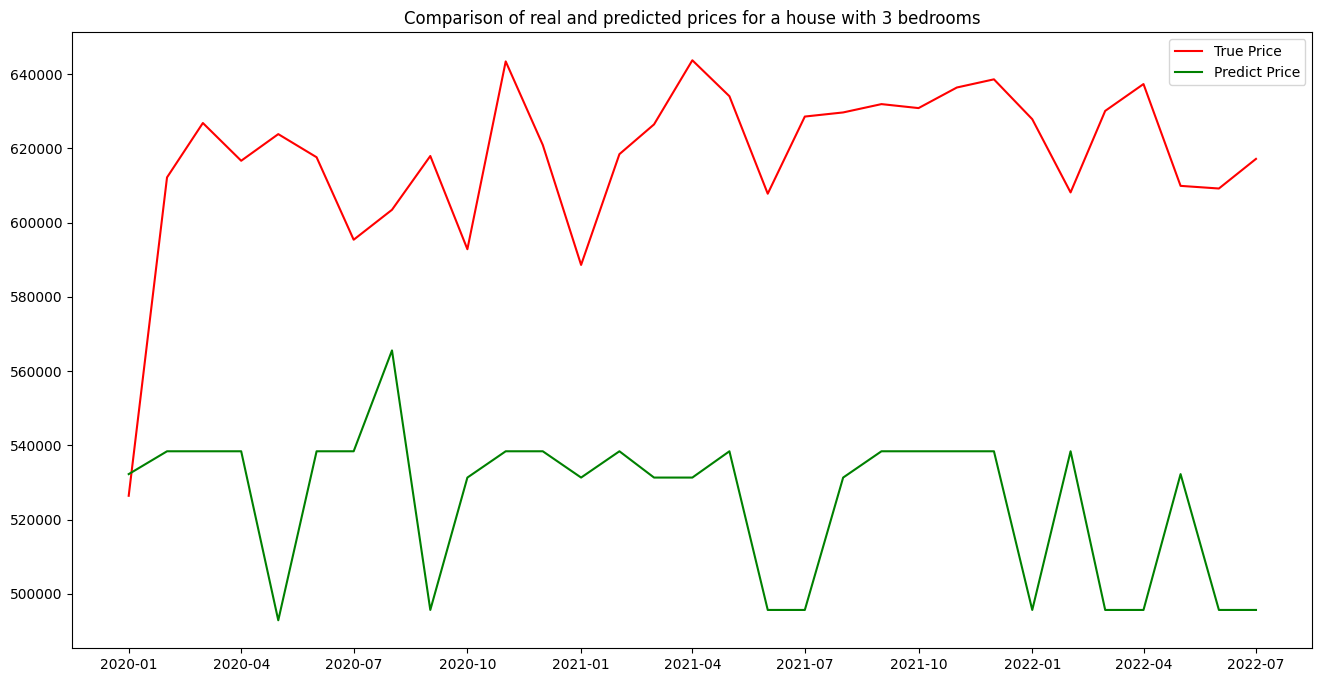

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(merged_df_pred['date'],merged_df_pred['price_True'],color='red',label='True Price')
plt.plot(merged_df_pred['date'],merged_df_pred['price_Pred'],color='green',label='Predict Price')
plt.legend(loc='best')
plt.title("Comparison of real and predicted prices for a house with 3 bedrooms")
plt.show()

#Comparison:


# C1. Create a plot contrasting the predictions of model A, model B, and the ground truth values from the test set.

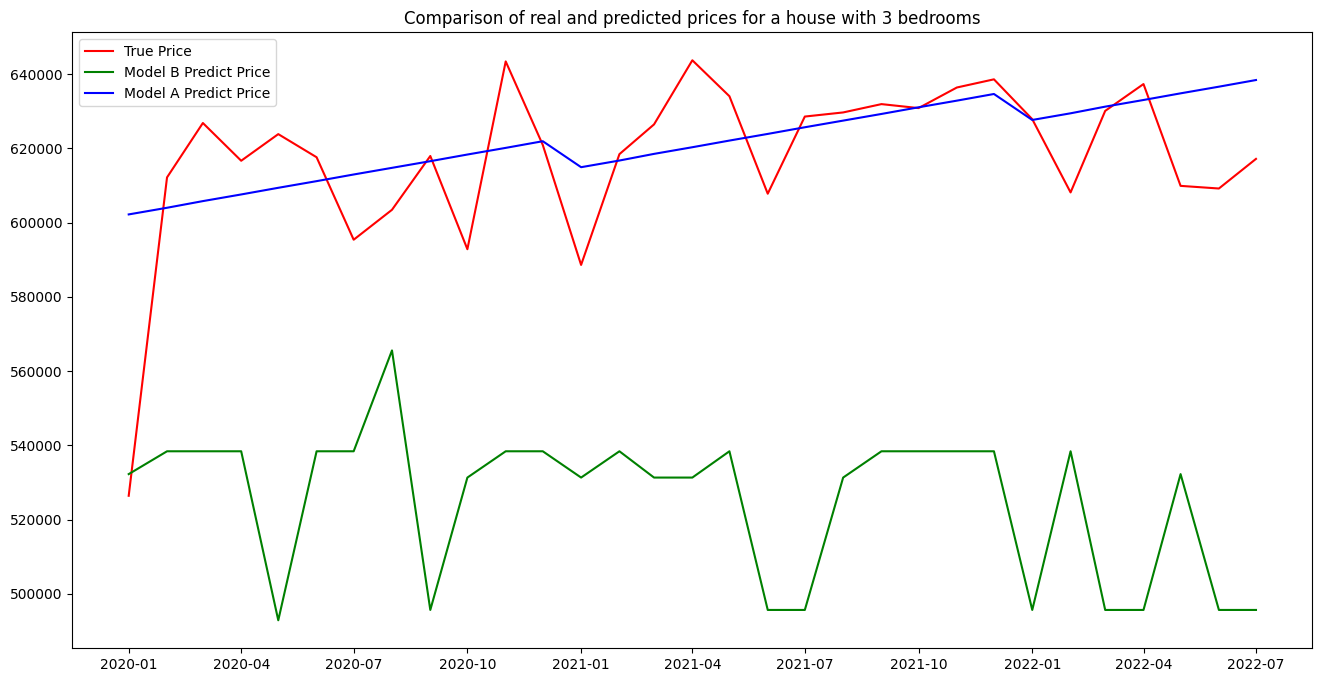

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(merged_df_pred['date'],merged_df_pred['price_True'],color='red',label='True Price')
plt.plot(merged_df_pred['date'],merged_df_pred['price_Pred'],color='green',label='Model B Predict Price')
plt.plot(dope['Year-Month'],results['Predicted'],color='blue',label='Model A Predict Price')
plt.legend(loc='best')
plt.title("Comparison of real and predicted prices for a house with 3 bedrooms")
plt.show()

# C2. Based on the results, which model would you recommend to the real estate company? Motivate your answer.

For modelB, the question requires that all properties must be used to train the model, but when we input all the values, we cannot get a better result due to the characteristics of the time series model, we consider the reason that the input time of the time series model is non-continuous.LSTM models are usually applied to sequential data, where there is only one value per time step. If there are multiple values at the same time step, it may make it difficult for the model to learn the correct patterns because it cannot distinguish the differences between these values. For a data set with multiple values at the same time step, we need to aggregate or average these values or select one of them as a representative value so that the model can learn the pattern correctly. However, since the question requires the use of all data, the results are poor for non-sequential values that have not been filtered.

Therefore we use the modelA to predict the future values, as model A does a better job in predicting future prices.

In [ ]:
%%shell
jupyter nbconvert --to html D:\Academics\TUe Modules\Data driven AI\Assignment_2_(Group_44)\Assignment_2_(Group_44)


/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `jupyter nbconvert --to html D:\Academics\TUe Modules\Data driven AI\Assignment_2_(Group_44)\Assignment_2_(Group_44)'


CalledProcessError: ignored